In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler   
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.algorithms import QSVC


In [ ]:
df = pd.read_csv('../stunting_dataset_10k.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Jenis Kelamin      200 non-null    int64  
 1   Umur (bulan)       200 non-null    int64  
 2   Tinggi Badan (cm)  200 non-null    float64
 3   Berat Badan (kg)   200 non-null    float64
 4   Stunting           200 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 7.9 KB


In [5]:
X = df.drop('Stunting', axis=1)
y = df['Stunting']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# --- 1. Reduksi dimensi ---
pca = PCA(n_components=0.98, svd_solver='full')   # jaga ≥95 % varians
X_train_red = pca.fit_transform(X_train_scaled)
X_test_red  = pca.transform(X_test_scaled)
num_qubits  = X_train_red.shape[1]

# --- 2. Quantum kernel ---
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement="linear")
sampler  = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
q_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# --- 3. SVM training ---
model = SVC(kernel=q_kernel.evaluate, C=1.0)
model.fit(X_train_red, y_train)

y_pred_train = model.predict(X_train_red)
y_pred_test   = model.predict(X_test_red)

print('train')
acc = accuracy_score(y_train, y_pred_train)
print(f"Akurasi train QSVM  : {acc:.3f}")
print("\n=== Classification Report ===")
print(classification_report(y_train, y_pred_train))

print('test')
acc = accuracy_score(y_test, y_pred_test)
print(f"Akurasi test QSVM  : {acc:.3f}")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_test))


KeyboardInterrupt: 

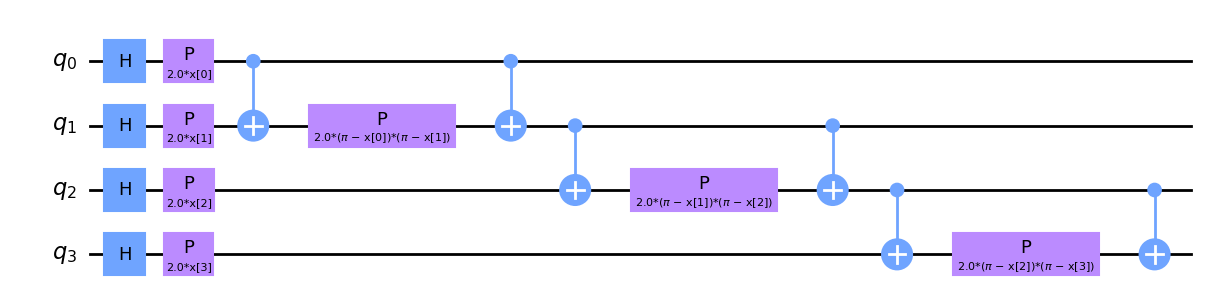

In [12]:
feature_map.decompose().draw(output="mpl", style="clifford", fold=100)